<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019-06-23-LSTM_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Prototype

Modeling this notebook after the following:

https://nbviewer.jupyter.org/github/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/12C%20-%20Sentiment%20Analysis%20-%20Advanced%20Deep%20Learning%20-%20LSTMs.ipynb



Making the following changes:

* last layer is a 5 node layer with softmax activation function since we are doing a 5 class classification
* Changing the loss function from binary_crossentropy to categorical_crossentropy since we are doing multi-class classification
* running fit with 50 epochs with early stopping with patience of 2

In [2]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
sys.path.append('drive/My Drive/Springboard/capstone')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import LSTM
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns


sns.set()

# import custom utilities
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu


In [0]:
DRIVE_DIR = "drive/My Drive/Springboard/capstone"

DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
FEATURE_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
QUANTILE = 0.99

In [8]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# df = pd.read_csv(f"{DATA_DIR}/{DATA_FILE}")
df = pd.read_csv(f"{DATA_FILE}")

In [10]:
df.head()

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date
0,48623501,R1G7J2VAMI4AEC,B00LBK7QBY,361030039,universal waterproof case joto cellphone dry b...,Wireless,5,0,0,good product please note not,good product please note not floating case do ...,2015-08-31
1,533148,R3Q4JAPXWCCJU7,B00W661MOO,360205932,car mount alpatronix mx101 universal charging ...,Wireless,5,0,0,great product holds phone place,great product holds phone place does not slip ...,2015-08-31
2,40266813,RJQWVO0QV2WQ4,B00USN9L0E,105913119,synthetic leather galaxy s6 sleeve thin,Wireless,5,0,0,exactly described,quality looks good prompt postage cannot argue...,2015-08-31
3,228806,R3RFPR7X60WN6C,B00YPAOKMU,564491128,jiake s6 5 0 inch unlocked smart phone quad co...,Wireless,5,0,0,powerful attractive really do love mode,works much like jiake phone love price great b...,2015-08-31
4,10866798,R3QL2UPH2B7YFT,B00O0S97SE,742788022,tfy universal car headrest mount holder portab...,Wireless,3,0,1,good enough,serves purpose loud whoever sitting seat attached,2015-08-31


In [0]:
rating = df[FEATURE_COLUMN]
reviews = df[REVIEW_COLUMN]

**Preprocessing**

In [12]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y

(112043,)
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [0]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)

In [0]:
train_sequences = t.texts_to_sequences(reviews_train)

In [16]:
train_sequences[:2]

[[20,
  24,
  16,
  11,
  1,
  21,
  2629,
  398,
  710,
  67,
  341,
  30,
  2290,
  153,
  140,
  13,
  1,
  28,
  186,
  396,
  20,
  16,
  93,
  370,
  1346,
  408,
  992],
 [99, 70, 31, 1, 168, 44, 1744, 452]]

In [0]:
# from collections import Counter

# tokenized_train = [tn.tokenizer.tokenize(text) for text in reviews_train]
# tokenized_test = [tn.tokenizer.tokenize(text) for text in reviews_test]

# # build word to index vocabulary
# token_counter = Counter([token for review in tokenized_train for token in review])
# vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
# max_index = np.max(list(vocab_map.values()))
# vocab_map['PAD_INDEX'] = 0
# vocab_map['NOT_FOUND_INDEX'] = max_index+1
# vocab_size = len(vocab_map)
# # view vocabulary size and part of the vocabulary map
# print('Vocabulary Size:', vocab_size)
# print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

# max_len = np.max([len(review) for review in tokenized_train])

# ## Train reviews data corpus
# # Convert tokenized text reviews to numeric vectors
# train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
# train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 

# ## Test reviews data corpus
# # Convert tokenized text reviews to numeric vectors
# test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
#            for token in tokenized_review] 
#               for tokenized_review in tokenized_test]
# test_X = sequence.pad_sequences(test_X, maxlen=max_len)

# # view vector shapes
# print('Max length of train review vectors:', max_len)
# print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

In [18]:
test_sequences = t.texts_to_sequences(reviews_test)
test_sequences[:2]

[[9,
  608,
  2584,
  670,
  437,
  246,
  2,
  323,
  5,
  31,
  203,
  340,
  1414,
  643,
  342,
  147,
  242,
  272,
  54,
  128,
  278,
  908,
  27],
 [764,
  1621,
  4,
  783,
  2,
  11,
  1,
  149,
  260,
  3,
  914,
  243,
  249,
  2369,
  2,
  9,
  105,
  11,
  3,
  131,
  94,
  128,
  10,
  21]]

In [19]:
print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


Vocabulary size=40788
Number of Documents=84032


**Sequence Normalization**

Figure out max length of review and pad the rest so they are all the same length

In [20]:
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
df.review_length.max()

2864

In [21]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,review_length
count,1.120430e+05,1.120430e+05,112043.000000,112043.000000,112043.000000,112043.000000
mean,2.547598e+07,4.994998e+08,3.889078,0.912435,1.189704,26.322965
std,1.582173e+07,2.879968e+08,1.463196,10.304687,11.167197,47.248166
min,1.014100e+04,1.365700e+04,1.000000,0.000000,0.000000,1.000000
25%,1.231110e+07,2.493906e+08,3.000000,0.000000,0.000000,8.000000
50%,2.344848e+07,4.990693e+08,5.000000,0.000000,0.000000,15.000000
75%,4.040851e+07,7.481358e+08,5.000000,0.000000,1.000000,29.000000
max,5.309655e+07,9.999930e+08,5.000000,1447.000000,1524.000000,2864.000000


In [22]:
df.review_length.quantile([0.95, 0.96, 0.97, 0.98, 0.99])

0.95     84.0
0.96     95.0
0.97    110.0
0.98    136.0
0.99    186.0
Name: review_length, dtype: float64

In [23]:
MAX_SEQUENCE_LENGTH = int(df.review_length.quantile([QUANTILE]).values[0])
MAX_SEQUENCE_LENGTH

186

Looks like 99% of our reviews have 186 words or less. If we keep our sequence length to around 186 words, this should allow us to keep most of our content

NOTE: no need to do encoding for our star_ratings since this is already in a number format

In [0]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [25]:
X_train[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [26]:
print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)

Train review vectors shape: (84032, 186)  Test review vectors shape: (28011, 186)


In [27]:
rating.head()

0    5
1    5
2    5
3    5
4    3
Name: star_rating, dtype: int64

In [0]:
MODEL_NAME = "LSTM_1layer"
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1
LSTM_DIM = 64 # total LSTM units



**Build LSTM Model Architecture**

In [29]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

W0723 06:11:56.878184 140325550856064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 06:11:56.894606 140325550856064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 06:11:56.898185 140325550856064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 06:11:56.928294 140325550856064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 06:11:56.942683 

In [30]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 186, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 12,330,465
Trainable params: 12,330,465
Non-trainable params: 0
_________________________________________________________________
None


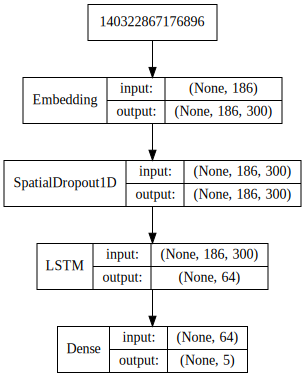

In [31]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
network_history = model.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0723 06:11:57.933832 140325550856064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 370s 6ms/step - loss: 0.9621 - acc: 0.6330 - val_loss: 0.8713 - val_acc: 0.6590
Epoch 2/50
67225/67225 [==============================] - 250s 4ms/step - loss: 0.7950 - acc: 0.6916 - val_loss: 0.8657 - val_acc: 0.6624
Epoch 3/50
67225/67225 [==============================] - 245s 4ms/step - loss: 0.7196 - acc: 0.7218 - val_loss: 0.8825 - val_acc: 0.6559
Epoch 4/50
67225/67225 [==============================] - 246s 4ms/step - loss: 0.6499 - acc: 0.7554 - val_loss: 0.9124 - val_acc: 0.6540
Epoch 00004: early stopping


In [33]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


28011/28011 [==============================] - 135s 5ms/step
Accuracy: 66.10%


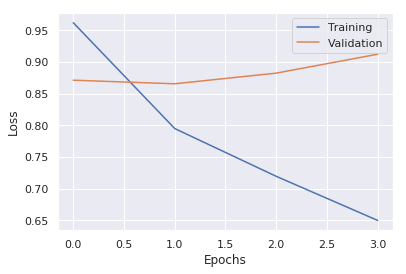

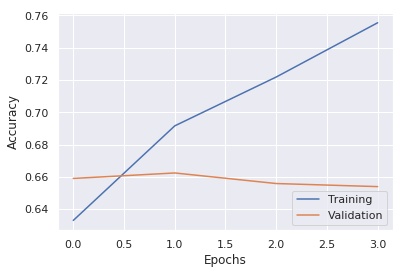

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

In [0]:
y_predict = model.predict(X_test)

In [36]:
y_predict_df = pd.DataFrame(y_predict)
y_predict_df.head()

,0,1,2,3,4
0,0.003629,0.004617,0.046413,0.291829,0.653511
1,0.006688,0.012077,0.096973,0.423838,0.460425
2,0.001060,0.000849,0.003945,0.082374,0.911772
3,0.086170,0.082153,0.099528,0.064521,0.667628
4,0.000342,0.000212,0.004047,0.082902,0.912497


In [0]:
y_predict_unencoded = [row.idxmax() + 1 for index, row in y_predict_df.iterrows()]

In [0]:
y_test_df = pd.DataFrame(y_test)
y_test_unencoded = [row.idxmax() + 1 for index, row in y_test_df.iterrows()]

In [39]:
confusion_matrix(y_test_unencoded, y_predict_unencoded)

array([[ 2801,   364,   388,   103,   312],
       [  663,   307,   466,   152,   283],
       [  361,   264,   774,   493,   639],
       [  121,   109,   510,  1137,  2875],
       [  180,    77,   308,   828, 13496]])

In [40]:
print(classification_report(y_test_unencoded, y_predict_unencoded))

              precision    recall  f1-score   support

           1       0.68      0.71      0.69      3968
           2       0.27      0.16      0.21      1871
           3       0.32      0.31      0.31      2531
           4       0.42      0.24      0.30      4752
           5       0.77      0.91      0.83     14889

    accuracy                           0.66     28011
   macro avg       0.49      0.46      0.47     28011
weighted avg       0.62      0.66      0.63     28011



In [0]:
from sklearn.metrics import roc_curve, auc
import numpy as np


def calculate_roc_auc(y_test, y_score):
  """
  Caculates the false positive rate, true positive rate, and roc_auc
  Return:
    roc_auc - dictinary of AUC values there will be 1 auc per class then a macro 
        and micro for the overall model
        keys: auc_0 to auc_{n_classes} + micro and macro
    fpr - dictionary of FPR, each value will be a n_classes x ? interpolated array 
        so you can plt ROC curve for each class
        keys: 0 to {n_classes} + micro and macro
    tpr - dictionary of TPR, each value will be a n_classes x ? interpolated array 
        so used to plt ROC curve for each class
        keys: 0 to {n_classes} + micro and macro    
  """
  n_classes = y_test.shape[1]
  
  # to compute the micro RUC/AUC, we need binariized labels (y_test) and probability of predictions y_predict_df

  fpr = {}
  tpr = {}
  roc_auc = {}
  for i in np.arange(0, 5):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[i].to_list())
      roc_auc[f'auc_{i + 1}'] = auc(fpr[i], tpr[i])


  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.values.ravel())
  roc_auc["auc_micro"] = auc(fpr["micro"], tpr["micro"])


  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally aveage it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["auc_macro"] = auc(fpr["macro"], tpr["macro"])

  return roc_auc, fpr, tpr


def plot_roc_auc(model_name, roc_auc, fpr, tpr):
  
  for i in np.arange(0, len(fpr.keys()) - 2):
    plt.plot(fpr[i], tpr[i], label=f'Rating {i+1}')
  plt.plot(fpr["micro"], tpr["micro"], label="Micro Average ROC", 
           linestyle=":", linewidth=4, color='pink')
  plt.plot(fpr["macro"], tpr["macro"], label="Macro Average ROC", 
           linestyle=":", linewidth=4, color='black')
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  
  space = 0
  for i in np.arange(0, len(fpr.keys()) - 2):
    plt.text(x=0, y=-0.25+space, 
      s=f'Rating {i + 1} AUC: {roc_auc[f"auc_{i + 1}"]}',
      withdash=True)
    space -= 0.05
  plt.text(x=0, y=-0.25+space, 
    s=f'Micro AUC: {roc_auc["auc_micro"]}',
    withdash=True)
  space -= 0.05
  plt.text(x=0, y=-0.25+space, 
    s=f'Macro AUC: {roc_auc["auc_macro"]}',
    withdash=True)
  
  plt.legend(loc='lower right')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title(f'{model_name} ROC AUC')
  


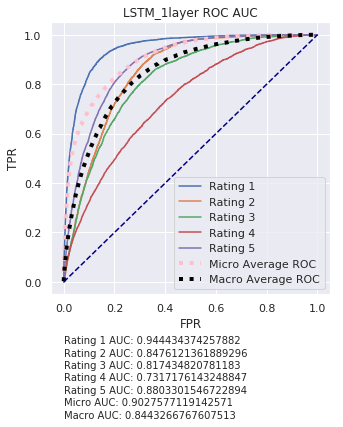

In [47]:
roc_auc, fpr, tpr = calculate_roc_auc(y_test, y_predict_df)
fig = plt.figure(figsize=(5,5))
plot_roc_auc(MODEL_NAME, roc_auc, fpr, tpr)

**Save off various files**

In [0]:
DESCRIPTION = f"{INBASENAME}-nosmote-{MODEL_NAME}-{MAX_SEQUENCE_LENGTH}-{FEATURE_COLUMN}"
MODEL_FILE = f"{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
REPORT_FILE = f"{datetime.now().strftime(DATE_FORMAT)}-DNN_protype-report.csv"
TOKENIZER_FILE = f'{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-tokenizer.pkl'


In [0]:
model.save(MODEL_FILE)

In [0]:
pickle.dump(network_history, open(NETWORK_HISTORY_FILE, "wb"))

In [0]:
pickle.dump(t, open(TOKENIZER_FILE, "wb"))

In [0]:
# saving off report in the same format as other report just in case we want to compare for later
flattened = {}
flattened = du.add_dict_to_dict(flattened, classification_report(y_test_unencoded, y_predict_unencoded, output_dict=True))
flattened = du.add_dict_to_dict(flattened, roc_auc)
flattened["fpr"] = fpr
flattened["tpr"] = tpr
flattened["loss"] = scores[0]
flattened["accuracy"] = scores[1]
flattened["confusion_matrix"] = confusion_matrix(y_test_unencoded, y_predict_unencoded)
flattened["description"] = DESCRIPTION
flattened["file"] = DATA_FILE
flattened["network_history_file"] = NETWORK_HISTORY_FILE
flattened["tokenizer_file"] = TOKENIZER_FILE
flattened["max_sequence_length"] = MAX_SEQUENCE_LENGTH
flattened["embedding"] = EMBED_SIZE
flattened["model_file"] = MODEL_FILE
flattened["model_name"] = MODEL_NAME
flattened["test_examples"] = X_test.shape[0]
flattened["test_features"] = X_test.shape[1]
flattened["train_examples"] = X_train.shape[0]
flattened["train_features"] = X_train.shape[1]
flattened["status"] = "success"
flattened["status_date"] = datetime.now().strftime(TIME_FORMAT)


In [49]:
# check to see if report file exisits, if so load it and append
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(flattened, ignore_index=True)
report_df.head()



,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,3_recall,3_support,4_f1-score,4_precision,4_recall,4_support,5_f1-score,5_precision,5_recall,5_support,accuracy,auc_1,auc_2,auc_3,auc_4,auc_5,auc_macro,auc_micro,confusion_matrix,description,embedding,file,fpr,loss,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,max_sequence_length,model_file,model_name,network_history_file,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
0,0.692118,0.678866,0.705897,3968.0,0.205214,0.273863,0.164083,1871.0,0.311031,0.316435,0.305808,2531.0,0.304622,0.419093,0.239268,4752.0,0.830676,0.7666,0.906441,14889.0,0.66099,0.944434,0.847612,0.817435,0.731718,0.88033,0.844327,0.902758,"[[2801, 364, 388, 103, 312], [663, 307, 466, 1...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,drive/My Drive/Springboard/capstone/data/amazo...,"{0: [0.0, 0.0, 0.0, 4.159214740257039e-05, 4.1...",0.898048,0.468732,0.490971,0.464299,28011.0,186.0,2019-07-23-amazon_reviews_us_Wireless_v1_00-pr...,LSTM_1layer,2019-07-23-amazon_reviews_us_Wireless_v1_00-pr...,success,2019-07-23 06:36:37,28011.0,186.0,2019-07-23-amazon_reviews_us_Wireless_v1_00-pr...,"{0: [0.0, 0.00025201612903225806, 0.0095766129...",84032.0,186.0,0.633073,0.62163,0.66099,28011.0


In [0]:
report_df.to_csv(REPORT_FILE, index=False)